In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import os

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

np.random.seed(10)
tf.random.set_seed(10)

In [4]:
# create a transfer learning model
def create_custom_model(input_shape=(96,96,3)):
    """
    returns: compiled keras model
    input_shape: dimensions of input images
    """
    model = keras.Sequential([
        # 1st block - focus 32x32 center
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # 2nd block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # 3rd block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # 4th block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Classification layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    return model

In [5]:
def load_and_process_image(path):
    # Use PIL for TIFF support
    img = Image.open(path)
    img_array = np.array(img).astype(np.float32) / 255.0
    return img_array


In [ ]:
def create_datasets(train_paths, train_labels, val_paths, val_labels, test_paths=None, batch_size=32):
    # Load training images in batches to manage memory
    train_images = []
    train_labels_list = []
    
    for i in range(0, len(train_paths), 1000):
        batch_paths = train_paths[i:i+1000]
        batch_labels = train_labels[i:i+1000]
        
        batch_images = []
        for path in batch_paths:
            img = load_and_process_image(path)
            batch_images.append(img)
        
        train_images.extend(batch_images)
        train_labels_list.extend(batch_labels)
        print(f"Loaded {min(i+1000, len(train_paths))}/{len(train_paths)} training images")
    
    train_images = np.array(train_images)
    train_labels_array = np.array(train_labels_list)
    
    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels_array))
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # Load validation images
    val_images = []
    for path in val_paths:
        img = load_and_process_image(path)
        val_images.append(img)
    
    val_images = np.array(val_images)
    val_labels_array = np.array(val_labels)
    
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels_array))
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # Load test images
    if test_paths is not None:
        test_images = []
        for i in range(0, len(test_paths), 1000):
            batch_paths = test_paths[i:i+1000]
            
            batch_images = []
            for path in batch_paths:
                img = load_and_process_image(path)
                batch_images.append(img)
            
            test_images.extend(batch_images)
            print(f"Loaded {min(i+1000, len(test_paths))}/{len(test_paths)} test images")
        
        test_images = np.array(test_images)
        test_dataset = tf.data.Dataset.from_tensor_slices(test_images)
        test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        
        return train_dataset, val_dataset, test_dataset
    
    return train_dataset, val_dataset

In [ ]:
def train_model(model, train_data, val_data, epochs=10):
    callbacks = [
        EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=2, min_lr=1e-6)
    ]
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

In [8]:
def predict_and_submit(model, test_dataset, test_paths, output_file='submission.csv'):
    predictions = model.predict(test_dataset)
    ids = [os.path.basename(path).split('.')[0] for path in test_paths]
    submission = pd.DataFrame({
        'id': ids,
        'label': (predictions > 0.5).astype(int).flatten()
    })
    submission.to_csv(output_file, index=False)
    print(f"Submission file created: {output_file}")

Training images: 176020
Validation images: 44005
Test images: 57458
Loaded 1000/176020 training images
Loaded 2000/176020 training images
Loaded 3000/176020 training images
Loaded 4000/176020 training images
Loaded 5000/176020 training images
Loaded 6000/176020 training images
Loaded 7000/176020 training images
Loaded 8000/176020 training images
Loaded 9000/176020 training images
Loaded 10000/176020 training images
Loaded 11000/176020 training images
Loaded 12000/176020 training images
Loaded 13000/176020 training images
Loaded 14000/176020 training images
Loaded 15000/176020 training images
Loaded 16000/176020 training images
Loaded 17000/176020 training images
Loaded 18000/176020 training images
Loaded 19000/176020 training images
Loaded 20000/176020 training images
Loaded 21000/176020 training images
Loaded 22000/176020 training images
Loaded 23000/176020 training images
Loaded 24000/176020 training images
Loaded 25000/176020 training images
Loaded 26000/176020 training images
Loade

c:\Users\basic\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1179s 212ms/step - accuracy: 0.8172 - auc: 0.8850 - loss: 0.4267 - val_accuracy: 0.8961 - val_auc: 0.9572 - val_loss: 0.2558 - learning_rate: 0.0010
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1191s 217ms/step - accuracy: 0.8988 - auc: 0.9583 - loss: 0.2515 - val_accuracy: 0.7456 - val_auc: 0.6276 - val_loss: 1.8570 - learning_rate: 0.0010
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1890s 344ms/step - accuracy: 0.9207 - auc: 0.9712 - loss: 0.2070 - val_accuracy: 0.8472 - val_auc: 0.9385 - val_loss: 0.4931 - learning_rate: 0.0010
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1221s 222ms/step - accuracy: 0.9360 - auc: 0.9794 - loss: 0.1735 - val_accuracy: 0.8416 - val_auc: 0.8878 - val_loss: 0.9251 - learning_rate: 5.0000e-04
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1095s 199ms/step - accuracy: 0.9447 - auc: 0.9835 - loss: 0.1546 - val_accuracy: 0.9334 - val_auc: 0.9822 - val_loss: 0.1794 - learning_rate: 5.0000e-04
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━

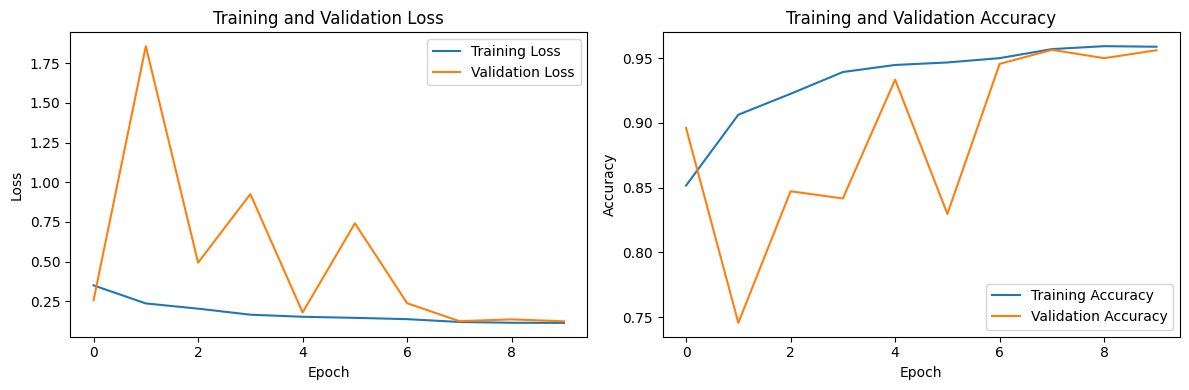

In [ ]:
def main():
    TRAIN_PATH = '../input/histopathologic-cancer-detection/train/'
    TEST_PATH = '../input/histopathologic-cancer-detection/test/'
    TRAIN_LABELS_PATH = '../input/histopathologic-cancer-detection/train_labels.csv'

    train_labels = pd.read_csv(TRAIN_LABELS_PATH)
    train_image_paths = [os.path.join(TRAIN_PATH, f"{id}.tif") for id in train_labels['id']]
    test_image_paths = [os.path.join(TEST_PATH, fname) for fname in os.listdir(TEST_PATH) if fname.endswith('.tif')]
    
    # Split data
    train_paths, val_paths, train_label_values, val_label_values = train_test_split(
        train_image_paths, train_labels['label'].values, test_size=0.2, random_state=42
    )
    
    print(f"Training images: {len(train_paths)}")
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_image_paths)}")
    
    # Create datasets
    train_dataset, val_dataset, test_dataset = create_datasets(
        train_paths, train_label_values,
        val_paths, val_label_values,
        test_image_paths, batch_size=32
    )
    
    # Create model
    model = create_custom_model()
    history = train_model(model, train_dataset, val_dataset, epochs=10)
    model.save('pcam_model.keras')
    
    # Predictions
    predict_and_submit(model, test_dataset, test_image_paths)
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')

if __name__ == "__main__":
    main()

In [ ]:
train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
class_dist = train_labels['label'].value_counts()

print(f"Class distribution:\n{class_dist}")
print(f"Percentage of tumor samples: {class_dist[1]/len(train_labels)*100:.2f}%")
print(f"Percentage of non-tumor samples: {class_dist[0]/len(train_labels)*100:.2f}%")

Class distribution:
label
0    130908
1     89117
Name: count, dtype: int64
Percentage of tumor samples: 40.50%
Percentage of non-tumor samples: 59.50%


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

df = pd.read_csv("../output/submission.csv")
sample_df = df.sample(100, random_state=42)

image_dir = "../input/histopathologic-cancer-detection/test"
X_sample = []
y_sample = []

for _, row in sample_df.iterrows():
    image_path = os.path.join(image_dir, row["id"] + ".tif")
    try:
        img = Image.open(image_path).convert("RGB").resize((96, 96))
        X_sample.append(np.array(img))
        y_sample.append(row["label"])
    except Exception as e:
        print(f"Skipping {image_path}: {e}")
        continue

X_sample = np.array(X_sample)
y_sample = np.array(y_sample)


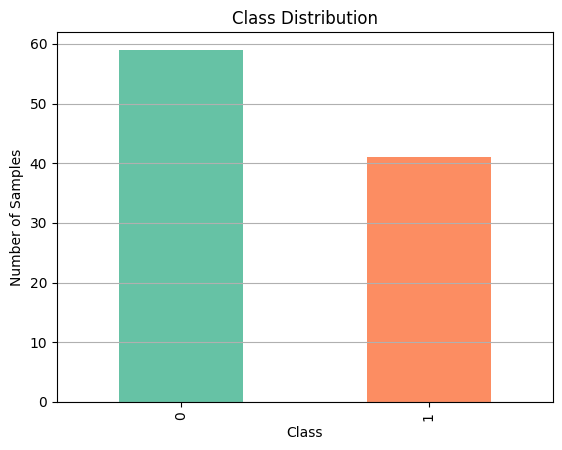

In [16]:
pd.Series(y_sample).value_counts().sort_index().plot(kind='bar', color=['#66c2a5', '#fc8d62'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks([0, 1])
plt.grid(axis='y')
plt.show()


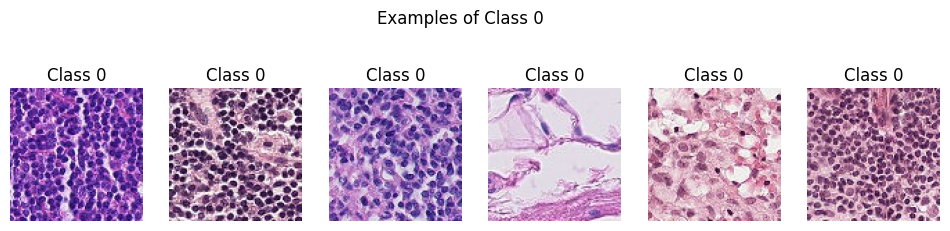

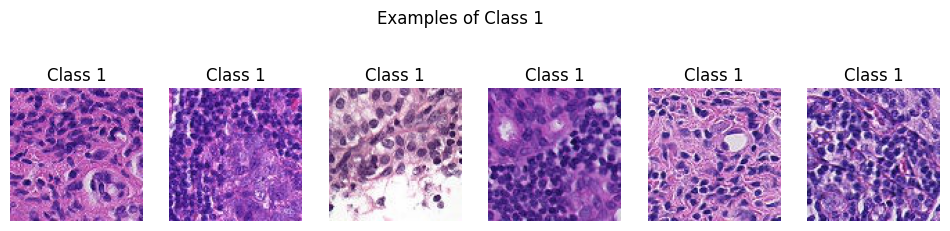

In [21]:
def plot_samples(X, y, class_label, n=6):
    indices = np.where(y == class_label)[0][:n]
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(X[idx])
        plt.title(f"Class {class_label}")
        plt.axis('off')
    plt.suptitle(f"Examples of Class {class_label}")
    plt.show()

plot_samples(X_sample, y_sample, 0)
plot_samples(X_sample, y_sample, 1)


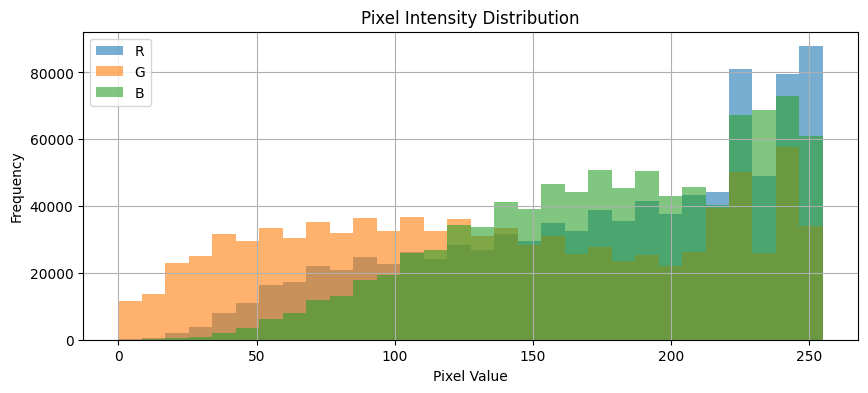

In [22]:
flattened = X_sample.reshape(-1, 3)
df = pd.DataFrame(flattened, columns=["R", "G", "B"])
df.plot(kind='hist', bins=30, alpha=0.6, figsize=(10, 4), title="Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.grid(True)
plt.show()


In [25]:
from tensorflow import keras

model = keras.models.load_model("../output/pcam_model.keras")
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,687,397 (67.47 MB)

 Trainable params: 5,894,817 (22.49 MB)

 Non-trainable params: 2,944 (11.50 KB)

 Optimizer params: 11,789,636 (44.97 MB)

In [29]:
import pandas as pd

labels_df = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
print(labels_df.head())


                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load model
model = keras.models.load_model("../output/pcam_model.keras")

# Sample subset of the data
sample_df = labels_df.sample(1000, random_state=42)

image_dir = "../input/histopathologic-cancer-detection/train"
y_true = []
y_pred = []

def preprocess_image(path):
    img = Image.open(path).convert("RGB").resize((96, 96))
    return np.array(img) / 255.0

for _, row in sample_df.iterrows():
    image_path = os.path.join(image_dir, row["id"] + ".tif")
    try:
        img_arr = preprocess_image(image_path)
        pred = model.predict(np.expand_dims(img_arr, axis=0), verbose=0)
        y_true.append(row["label"])
        y_pred.append(int(pred[0][0] > 0.5))
    except Exception as e:
        print(f"Skipping {row['id']}: {e}")

# Metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification report:\n", classification_report(y_true, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_true, y_pred))


Accuracy: 0.966

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       590
           1       0.95      0.97      0.96       410

    accuracy                           0.97      1000
   macro avg       0.96      0.97      0.96      1000
weighted avg       0.97      0.97      0.97      1000


Confusion matrix:
 [[568  22]
 [ 12 398]]


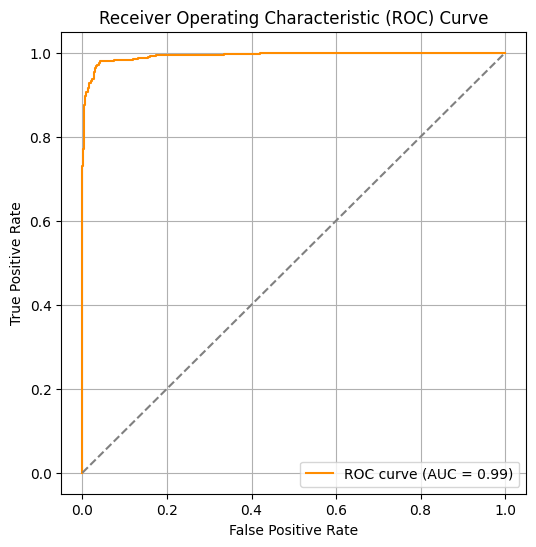

In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = []

for _, row in sample_df.iterrows():
    image_path = os.path.join(image_dir, row["id"] + ".tif")
    try:
        img_arr = preprocess_image(image_path)
        prob = model.predict(np.expand_dims(img_arr, axis=0), verbose=0)
        y_prob.append(prob[0][0])
    except Exception as e:
        print(f"Skipping {row['id']}: {e}")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
